# Setup

In [129]:
# Import libraries
import pandas as pd
import yaml
from sklearn.ensemble import HistGradientBoostingClassifier
import sklearn.metrics
from joblib import dump, load
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# Import configuration file
with open("config.yaml") as config_file:
    config = yaml.safe_load(config_file)

In [130]:
# Construct the output filenames
version_name = config["input"]["version_name"]

num_iterations = config["boosting_parameters"]["num_iterations"]        # m
max_depth = config["boosting_parameters"]["max_depth"]                  # d
learning_rate = config["boosting_parameters"]["learning_rate"]          # a

tag = f"{version_name}(m={num_iterations},d={max_depth},a={learning_rate})"
output_folder = f"output-data/{tag}"

# Make the output directory if it doesn't exist
Path(output_folder).mkdir(parents=True, exist_ok=True)

model_df_filename = f"{output_folder}/model_dump_{tag}.joblib"

train_pred_prob_filename = f"{output_folder}/train_pred_prob_{tag}.npy" # binary for 3D
test_pred_prob_filename = f"{output_folder}/test_pred_prob_{tag}.npy"   # binary for 3D

train_log_loss_filename = f"{output_folder}/train_log_loss_{tag}.csv" # csv for 1D
test_log_loss_filename = f"{output_folder}/test_log_loss_{tag}.csv"   # csv for 1D

log_loss_plot_filename = f"{output_folder}/log_loss_plot_{tag}.png"

# Import the data

In [131]:
# Import the dataframes
train_df = pd.read_csv(config["input"]["train_df_filename"], index_col = 0)     # use the pre-existing indices
test_df = pd.read_csv(config["input"]["test_df_filename"], index_col = 0)

In [132]:
# Process the dataframes as categorized (lost when written to CSV)
CATEGORY_COLUMN_NAMES = ["workclass", "education", "marital.status", "occupation", "relationship", "race", "sex", "native.country", "income"]
NUMBER_COLUMN_NAMES = ["age", "education.num", "capital.gain", "capital.loss", "hours.per.week"] # also fnlwgt, technically (but this is not in the frame)

# Categorize in place
def categorize(df):
    for categorical_column_name in CATEGORY_COLUMN_NAMES:
        df[categorical_column_name] = df[categorical_column_name].astype('category')

categorize(train_df)
categorize(test_df)

In [133]:
# Split into X and y
def get_X_y (df):
    return (df.drop("income", axis = 1), df["income"])

train_X, train_y = get_X_y(train_df)
test_X, test_y = get_X_y(test_df)

# Train boosted classifier

In [134]:
# Set up the boosting classifier with the provided parameters
classifier = HistGradientBoostingClassifier(
    loss = 'log_loss',
    categorical_features = 'from_dtype', 
    early_stopping = False,

    max_iter = num_iterations,
    max_depth = max_depth,
    learning_rate = learning_rate
)

In [135]:
# Train the classifier on the train data and dump
classifier.fit(train_X, train_y)
dump(classifier, model_df_filename)

['output-data/v1(m=5000,d=2,a=0.1)/model_dump_v1(m=5000,d=2,a=0.1).joblib']

# Evaluate boosted classifier

In [136]:
# Report final accuracy
print(f"Train accuracy = {classifier.score(train_X, train_y)}")
print(f"Test accuracy = {classifier.score(test_X, test_y)}")

Train accuracy = 0.9268571428571428
Test accuracy = 0.8746666666666667


In [137]:
# Compute and save the staged predictions. Shape = (m, n, 2) (2 = one for each probability)
staged_train_pred_prob = np.array([pred_prob for pred_prob in classifier.staged_predict_proba(train_X)])
staged_test_pred_prob = np.array([pred_prob for pred_prob in classifier.staged_predict_proba(test_X)])

In [138]:
# Saved staged predictions to provided binary files
np.save(train_pred_prob_filename, staged_train_pred_prob)
np.save(test_pred_prob_filename, staged_test_pred_prob)

In [139]:
# Compute the staged log loss for train and test. Shape = (,)
staged_train_log_loss = np.array([sklearn.metrics.log_loss(train_y, pred_prob) for pred_prob in staged_train_pred_prob])
staged_test_log_loss = np.array([sklearn.metrics.log_loss(test_y, pred_prob) for pred_prob in staged_test_pred_prob])

In [140]:
# Saved staged log loss predictions to provided binary files
np.savetxt(train_log_loss_filename, staged_train_log_loss)
np.savetxt(test_log_loss_filename, staged_test_log_loss)

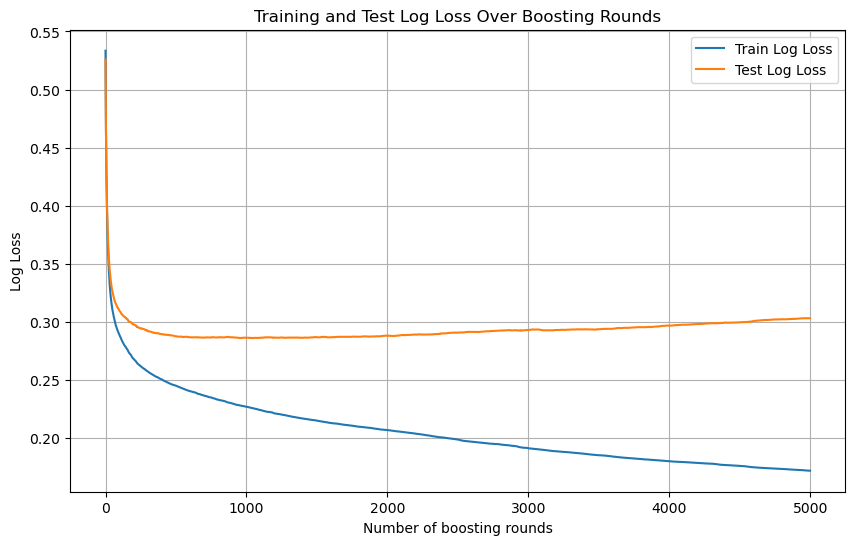

In [141]:
# Create graphs of log loss
plt.figure(figsize=(10, 6))
plt.plot(staged_train_log_loss, label='Train Log Loss')
plt.plot(staged_test_log_loss, label='Test Log Loss')

# Add labels and title
plt.xlabel('Number of boosting rounds')
plt.ylabel('Log Loss')
plt.title('Training and Test Log Loss Over Boosting Rounds')
plt.legend()  # Show legend
plt.grid(True)  # Optional: add a grid


# Save the plot
plt.savefig(log_loss_plot_filename)

# Show the plot (must be after saving)
plt.show()

In [142]:
# # Reshape staged_train_pred_prob to (num_iterations * num_samples , 2)
# reshaped_staged_train_pred_prob = staged_train_pred_prob.reshape(-1, 2)

# # # Repeat train_y 1000 times to match the shape of reshaped_pred_prob
# # repeated_train_y = np.tile(train_y, )

# # # Compute the log loss across the entire reshaped array, then reshape the result back to (1000,)
# # staged_train_log_loss = log_loss(repeated_train_y, reshaped_pred_prob, labels=[0, 1], sample_weight=np.repeat(1/5000, 5000)).reshape(1000)